In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [0]:
## Use if PC change to directory
# os.chdir()

In [2]:
## Use if Google Colab
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
## Google Colab copy over files
#!cp '' utils.py
#!cp '' OneCycleScheduler.py

In [2]:
# Import OneCycleScheduler, LRFinder, and simple_cnn
from utils import *
from OneCycleScheduler import *

#### Load cifar10 dataset

In [0]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # load train and test sets
x_train, x_test = x_train/255., x_test/255. # normalize to between 0-1 for each channel
y_train = tf.keras.utils.to_categorical(y_train) # one-hot-encode labels
y_test = tf.keras.utils.to_categorical(y_test) # same for test set
num_classes = y_train.shape[1] # set number of classes (10)

In [0]:
## Build simple cnn and use LRfinder to get learning rate
model = simple_cnn([32,64,128,num_classes],(32,32,3), strides=[1,1,1], dropout=[0.2,0.2,0.1])

In [56]:
bs = 32 # batch size
steps_per_epoch = len(x_train)/bs # how many steps to cycle through the training set in one epoch

lr_finder = LRFinder(max_steps=steps_per_epoch) # setup lrfinder. See document for max_lr and min_lr

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

_ = model.fit(x_train,
              y_train,
              batch_size=bs,
              steps_per_epoch=steps_per_epoch,
              callbacks=[lr_finder])

1563/1562 [==============================] - 8s 5ms/step - loss: 1483.4882 - accuracy: 0.1808


(2.0, 3.0)

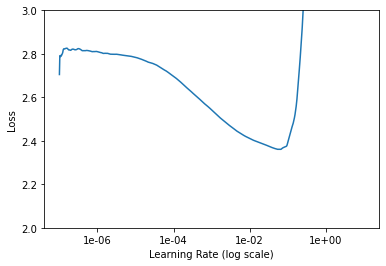

In [57]:
fig, ax = lr_finder.plot()
ax.set_ylim([2,3])
# 1e-2 seems pretty good, let's take a look at change in loss

(-0.001, 0.0)

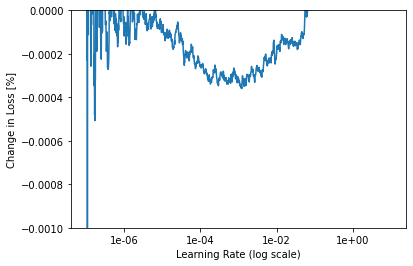

In [58]:
fig, ax = lr_finder.plot_changes()
ax.set_ylim([-0.001,0])
# 1e-3 learning rate seems to lead to the largest change in loss.

### Train CNN without One Cycle Scheduler

In [122]:
## Build CNN
model = simple_cnn(nfilters=[32,64,128,num_classes],
                   inputshape=(32,32,3),
                   strides = [1,1,1], 
                   dropout=[0.2,0.2,0.1])

bs = 32
steps_per_epoch = len(x_train)/bs
epochs= 5 

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), # set learning rate to 1e-3
              loss='categorical_crossentropy',
              metrics='accuracy')

history_nocycle = model.fit(x_train,
                    y_train,
                    batch_size=bs,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data = (x_test,y_test))

Epoch 1/5
1563/1562 [==============================] - 14s 9ms/step - loss: 1.8342 - accuracy: 0.5107 - val_loss: 1.4194 - val_accuracy: 0.5680
Epoch 2/5
1563/1562 [==============================] - 13s 9ms/step - loss: 0.9425 - accuracy: 0.6825 - val_loss: 0.9753 - val_accuracy: 0.6695
Epoch 3/5
1563/1562 [==============================] - 13s 9ms/step - loss: 0.7353 - accuracy: 0.7444 - val_loss: 1.0275 - val_accuracy: 0.6591
Epoch 4/5
1563/1562 [==============================] - 13s 9ms/step - loss: 0.6170 - accuracy: 0.7874 - val_loss: 0.9476 - val_accuracy: 0.6901
Epoch 5/5
1563/1562 [==============================] - 13s 9ms/step - loss: 0.5177 - accuracy: 0.8195 - val_loss: 0.9135 - val_accuracy: 0.7054


### Train CNN with One Cycle Scheduler

In [124]:
## Build simple cnn and use LRfinder to get learning rate
model = simple_cnn(nfilters=[32,64,128,num_classes],
                   inputshape=(32,32,3),
                   strides = [1,1,1], 
                   dropout=[0.2,0.2,0.1])

bs = 32
steps_per_epoch = len(x_train)/bs
epochs= 5

## setup scheduler
# note that here I set steps_size to be half the number of steps needed to complete
# a whole training cycle. The reason is that the step_size is the number of
# steps to reach max_lr, and so if you want one cycle to go through 
# the entire training data, you should use half the number of steps_per_epoch (defined above).
lr_scheduler = OneCycleScheduler(max_lr = 5e-3, # default is 0.6
                                 base_mom = 0.95, # default is 0.9 for both base and min
                                 min_mom = 0.85,
                                 step_size = steps_per_epoch/2)

model.compile(optimizer=tf.keras.optimizers.Adam(), # no need to setup lr here, it's controlled by the scheduler.
              loss='categorical_crossentropy',
              metrics='accuracy')

history = model.fit(x_train,
                    y_train,
                    batch_size=bs,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data = (x_test,y_test),
                    callbacks=[lr_scheduler]) # add scheduler as callback

Epoch 1/5
1563/1562 [==============================] - 16s 10ms/step - loss: 1.6726 - accuracy: 0.5333 - val_loss: 0.9329 - val_accuracy: 0.6769
Epoch 2/5
1563/1562 [==============================] - 16s 10ms/step - loss: 0.9462 - accuracy: 0.6736 - val_loss: 0.8613 - val_accuracy: 0.6988
Epoch 3/5
1563/1562 [==============================] - 17s 11ms/step - loss: 0.8620 - accuracy: 0.7008 - val_loss: 0.8316 - val_accuracy: 0.7118
Epoch 4/5
1563/1562 [==============================] - 16s 10ms/step - loss: 0.7933 - accuracy: 0.7239 - val_loss: 0.8233 - val_accuracy: 0.7163
Epoch 5/5
1563/1562 [==============================] - 16s 10ms/step - loss: 0.7325 - accuracy: 0.7483 - val_loss: 0.8327 - val_accuracy: 0.7156


### Compare validation loss

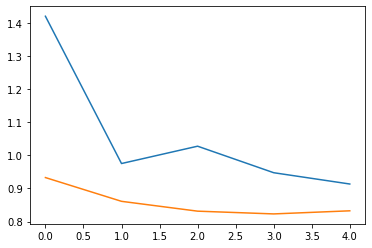

In [128]:
plt.plot(history_nocycle.history['val_loss'])
plt.plot(history.history['val_loss'])
# orange = with scheduler; blue = without scheduler

### Taking a look at the LR and momentum cycles

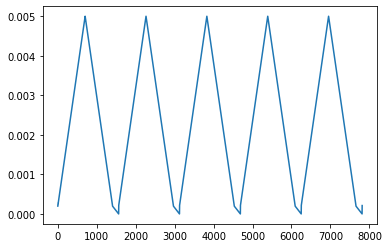

In [131]:
plt.plot(lr_scheduler.history['lr'])

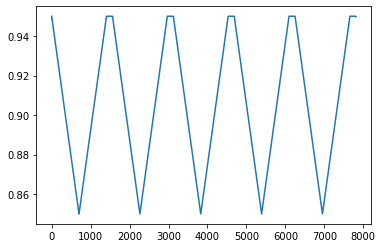

In [133]:
plt.plot(lr_scheduler.history['mom'])